In [4]:
!pip install opencv-python


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 18.6 MB/s eta 0:00:0000:0100:01


Sky View Factor: 0.640


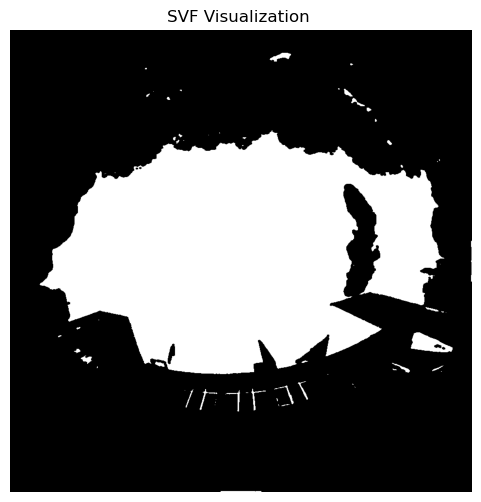

SVF visualization saved to: ./svf_visualized_image.png


In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the fisheye image
image_path = "image (16).png"  # Update path if needed
image = cv2.imread(image_path)

# Step 1: Convert the image to grayscale (or HSV for more advanced filtering)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Step 2: Basic threshold to identify sky
_, intensity_mask = cv2.threshold(gray, 180, 255, cv2.THRESH_BINARY)

# Step 3: Edge detection to remove strong edges
edges = cv2.Canny(gray, 50, 220)

# Step 4: Combine masks to refine sky region
combined_mask = cv2.bitwise_and(intensity_mask, cv2.bitwise_not(edges))

# Step 5: Create circular mask (valid fisheye region)
height, width = combined_mask.shape
center = (width // 2, height // 2)
radius = min(center)

y, x = np.ogrid[:height, :width]
circular_mask = (x - center[0])**2 + (y - center[1])**2 <= radius**2
combined_mask[~circular_mask] = 0

# Step 6: Clean up mask with morphological closing
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
cleaned_mask = cv2.morphologyEx(combined_mask, cv2.MORPH_CLOSE, kernel)

# Step 7: Annulus-Based SVF Calculation (sin-weighted)
def compute_svf_annulus(binary_mask, n_rings=36):
    h, w = binary_mask.shape
    cx, cy = w // 2, h // 2
    radius = min(cx, cy)

    yy, xx = np.ogrid[:h, :w]
    dx = xx - cx
    dy = yy - cy
    r = np.sqrt(dx**2 + dy**2)
    theta = (r / radius) * (np.pi / 2)

    sky_mask = (binary_mask > 0).astype(np.uint8)

    svf_sum = 0
    for i in range(1, n_rings + 1):
        r_inner = (i - 1) * radius / n_rings
        r_outer = i * radius / n_rings

        annulus = (r >= r_inner) & (r < r_outer)
        t_i = np.sum(annulus)
        if t_i == 0:
            continue

        p_i = np.sum(sky_mask[annulus])
        theta_i = (np.pi * (2 * i - 1)) / (2 * n_rings)
        weight = np.sin(theta_i)

        svf_sum += weight * (p_i / t_i)

    svf = (np.pi / (2 * n_rings)) * svf_sum
    return svf

# Compute SVF using annulus method
svf_annulus = compute_svf_annulus(cleaned_mask, n_rings=36)
print(f"Sky View Factor: {svf_annulus:.3f}")

# Step 8: Overlay SVF on image and visualize
overlay_image = cv2.cvtColor(cleaned_mask, cv2.COLOR_GRAY2BGR)
# cv2.putText(overlay_image, f"SVF = {svf_annulus:.3f}", (80, 80),
#             cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2, cv2.LINE_AA)

# Save and show the result
output_path = "./svf_visualized_image.png"
cv2.imwrite(output_path, overlay_image)

plt.figure(figsize=(6, 6))
plt.imshow(cv2.cvtColor(overlay_image, cv2.COLOR_BGR2RGB))
plt.title("SVF Visualization ")
plt.axis("off")
plt.show()

print(f"SVF visualization saved to: {output_path}")
